In [1]:
"""
@author: albertigno

"""

from MyDataset import *
import torch, time, os
import torch.nn as nn
import torch.nn.functional as F
#import networkx as nx
import matplotlib.pyplot as plt
#from matplotlib.gridspec import GridSpec

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ('Running on: {}'.format(device))

dataset = 'shd'
dataset_path = r'./../../datasets'
thresh = 0.3

if dataset == 'shd':
    batch_size = 256 # default 256
    learning_rate = 1e-4 # default 1e-4
    time_window = 50 # shd 50, nmnist 25-30
    train_path = dataset_path+'/shd_digits/shd_train.h5'
    test_path = dataset_path+'/shd_digits/shd_test.h5'
    ds_method_train = 'hd_digits'
    ds_method_test = 'hd_digits'
else:
    batch_size = 40 
    learning_rate = 1e-4
    time_window = 25     
    train_path = dataset_path+'/nmnist/nmnist_train.mat'
    test_path = dataset_path+'/nmnist/nmnist_test.mat'        
    ds_method_train = 'nmnist_h'
    ds_method_test = 'nmnist_r'    

Running on: cuda:0


In [2]:
from snn_models_monitor import *
%load_ext autoreload
%autoreload 1
%aimport snn_models_monitor

#tau_m = 'adp'
tau_m = 0.8305
#snn = RSNN_delay(d='shd', num_hidden=128, thresh=0.3, decay=0.3, batch_size=batch_size, win=50, device=device)
#snn = RSNN_monitor('shd', num_hidden=512, thresh=0.3, tau_m=tau_m, batch_size=batch_size, win=time_window, device=device)
snn = RSNN_monitor(dataset, num_hidden=512, thresh=0.3, tau_m=tau_m, batch_size=batch_size, win=time_window, device=device)
snn.to(device)

RSNN_monitor(
  (fc_ih): Linear(in_features=700, out_features=512, bias=False)
  (fc_hh): Linear(in_features=512, out_features=512, bias=False)
  (fc_ho): Linear(in_features=512, out_features=20, bias=False)
)

<AxesSubplot:title={'center':'hidden-to-hidden weight distribution'}, xlabel='weight', ylabel='frequency'>

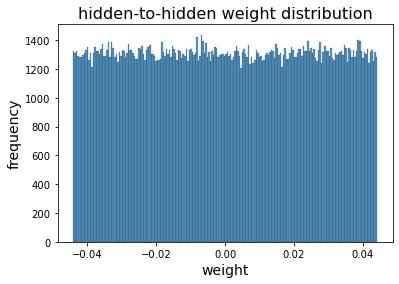

In [3]:
snn.plot_weights('hh')

In [4]:
# load datasets
print("loading test set...")
test_dataset = MyDataset(test_path, ds_method_test, time_window, device)
print("loading training set...")
train_dataset = MyDataset(train_path, ds_method_train, time_window, device)
print("loading data with pytorch")
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False, drop_last=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True, drop_last=True)

loading test set...
num sample: 2264
torch.Size([2264, 50, 700]) torch.Size([2264, 20])
loading training set...
num sample: 8156
torch.Size([8156, 50, 700]) torch.Size([8156, 20])
loading data with pytorch


In [5]:
# training configuration

num_epochs = 15
modelname = 'shd_rnn_{}_{}.t7'.format(snn.num_hidden, tau_m)
num_samples = train_dataset.images.size()[0]

#optimizer = torch.optim.Adam(snn.parameters(), lr=learning_rate)

# set different learning rates
base_params = [snn.fc_ih.weight,
               snn.fc_hh.weight,
               snn.fc_ho.weight, 
               ]
if tau_m=='adp':
    print('tau_m_h ')
    optimizer = torch.optim.Adam([
        {'params': base_params},
        {'params': snn.tau_m_h, 'lr': learning_rate * 10.0}],
        lr=learning_rate)
else:    
    optimizer = torch.optim.Adam([
        {'params': base_params}],
        lr=learning_rate)
    
act_fun = ActFun.apply
print(modelname)

shd_rnn_512_0.8305.t7


In [6]:
# training loop
taus_m = []
for epoch in range(num_epochs):
    print('Epoch [%d/%d]'  % (epoch + 1, num_epochs))
    start_time = time.time()
    snn.train_step(train_loader, optimizer=optimizer, criterion=nn.MSELoss(), num_samples = num_samples, spkreg=0.0)
    print('Time elasped:', time.time() - start_time)
    
    # update learning rate
    optimizer = snn.lr_scheduler(optimizer, lr_decay_epoch=1)
    
    # weight and decay recording
    taus_m.append((snn.tau_m_h.data.detach().clone(), snn.tau_m_o.data.detach().clone()))
    
    if (epoch + 1) % 5 == 0:
        snn.test(test_loader, criterion=nn.MSELoss())
        #snn.save_model(modelname)   

Epoch [1/15]
Step [10/31], Loss: 0.49102
Step [20/31], Loss: 0.47827
Step [30/31], Loss: 0.46915
Time elasped: 3.07838773727417
Epoch [2/15]
Step [10/31], Loss: 0.45469
Step [20/31], Loss: 0.44821
Step [30/31], Loss: 0.44143
Time elasped: 2.6696858406066895
Epoch [3/15]
Step [10/31], Loss: 0.43131
Step [20/31], Loss: 0.42739
Step [30/31], Loss: 0.41876
Time elasped: 2.648585319519043
Epoch [4/15]
Step [10/31], Loss: 0.40729
Step [20/31], Loss: 0.39753
Step [30/31], Loss: 0.39118
Time elasped: 2.6999635696411133
Epoch [5/15]
Step [10/31], Loss: 0.37578
Step [20/31], Loss: 0.37067
Step [30/31], Loss: 0.36189
Time elasped: 2.659755229949951
avg spk_count per neuron for all 50 timesteps 10.589250564575195
Test Accuracy of the model on the test samples: 47.998
Epoch [6/15]
Step [10/31], Loss: 0.35471
Step [20/31], Loss: 0.34942
Step [30/31], Loss: 0.35313
Time elasped: 2.6475863456726074
Epoch [7/15]
Step [10/31], Loss: 0.34080
Step [20/31], Loss: 0.32976
Step [30/31], Loss: 0.32452
Time el

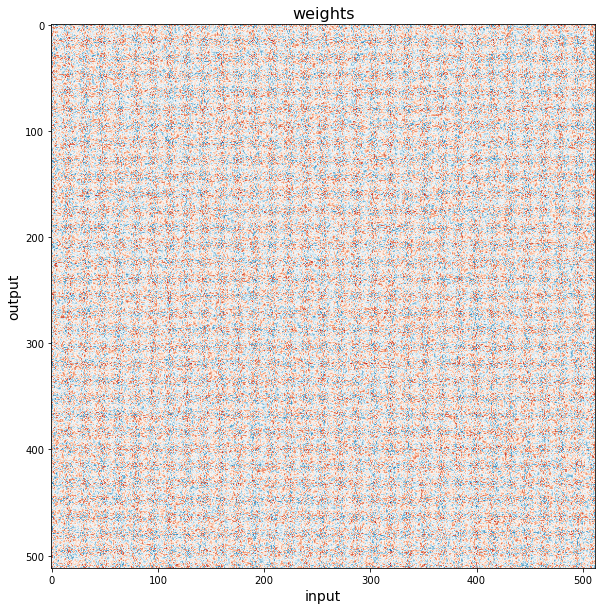

In [7]:
fig = snn.plot_weights('hh', 'matrix')

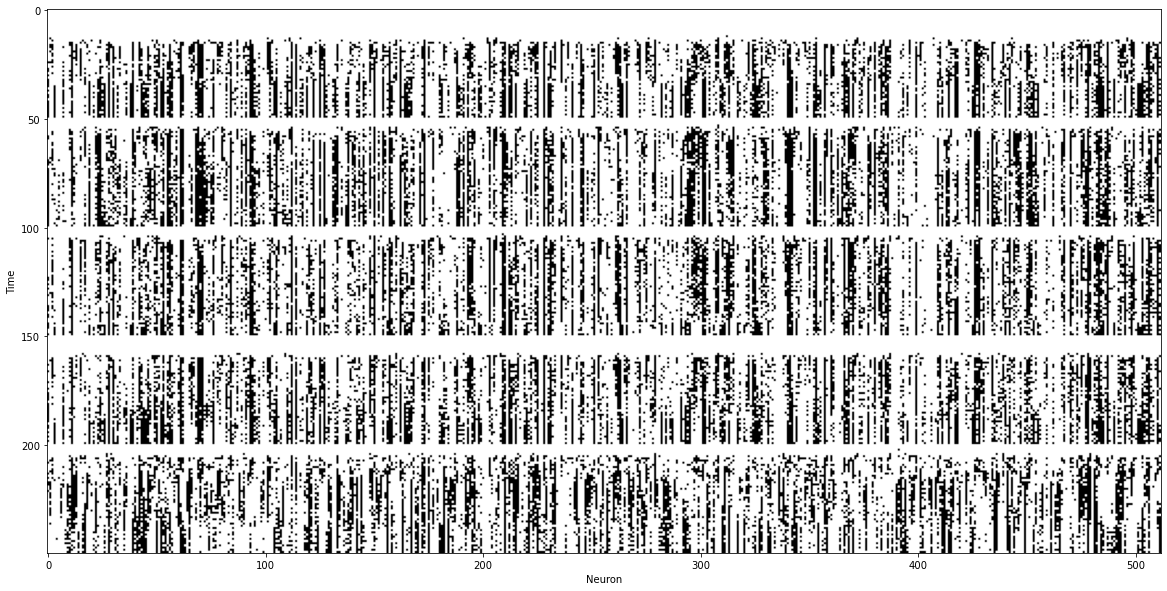

In [8]:
fig = snn.plot_activity('h','spike','normal', [0,1,2,3,4])

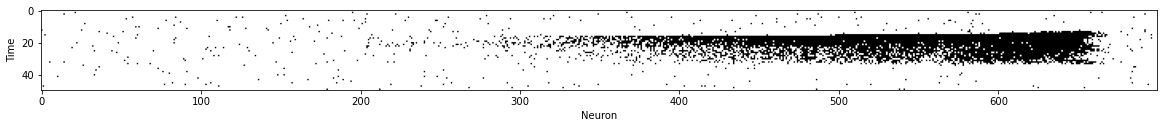

In [9]:
fig = snn.plot_activity('x','spike','normal', range(1))

[0, 1, 2]
[0, 1]
torch.Size([50, 256, 512])
torch.Size([3, 100])


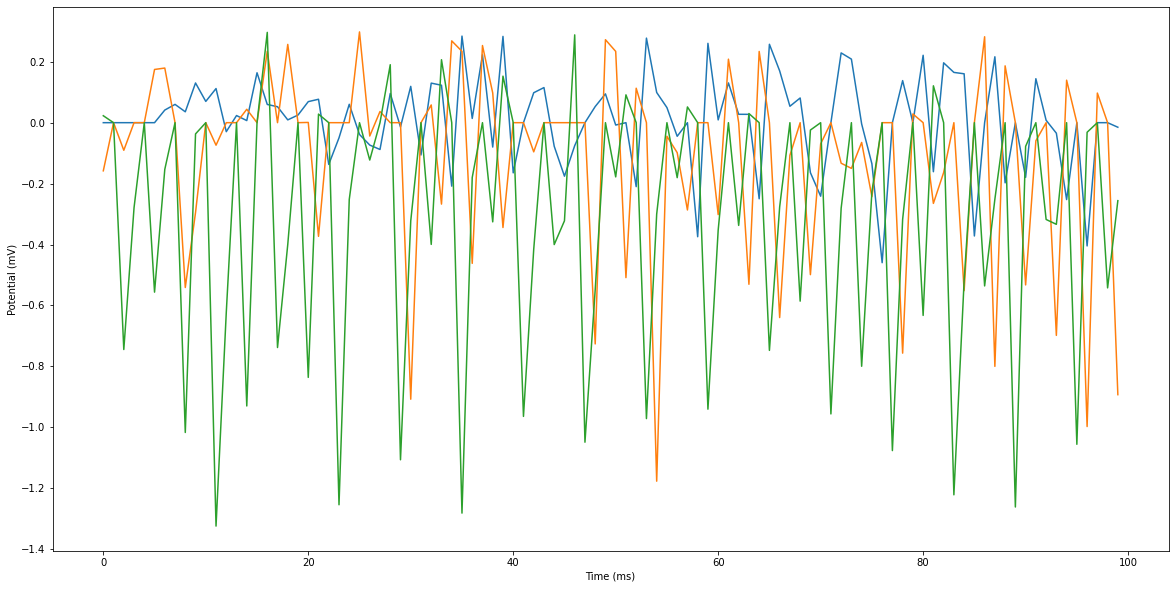

In [10]:
# neuron_id -> id of neurons to display
# sample_id -> id of sample to display
fig = snn.plot_mem('h', neuron_id =[0, 1, 2], sample_id = [0,1])

In [11]:
def square(num):
    '''
    get two closest factors of num so we can plot a vector of length num as an square-ish matrix
    '''
    factor1 = [x for x in range(1,num+1) if num%x==0 ]
    factor2 = [int(num/x) for x in factor1]
    idx = np.argmin(np.abs(np.array(factor2) - np.array(factor1)))
    return factor1[idx], factor2[idx]

<IPython.core.display.Javascript object>


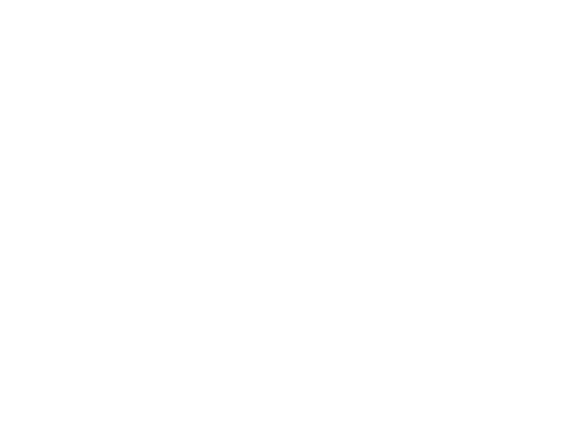

In [12]:
%matplotlib notebook
from matplotlib.animation import FuncAnimation

xh, yh = square(snn.num_hidden)

hidden_spk = snn.all_h_spike.permute(1,0,2).flatten(0,1).view(-1, xh, yh).detach().cpu().numpy()

output_spk = snn.all_o_spike.view(-1,snn.num_output).detach().cpu().numpy()

num_channels = 1

ni = int(snn.num_input / num_channels)
xx, yx = square(ni)

hidden_spk[0,0,0] = 1.0

fig = plt.figure()

gs = fig.add_gridspec(2,2)

if num_channels==1:
    ax1 = fig.add_subplot(gs[:, 0])
    x_spk = snn.all_x.permute(1,0,2).flatten(0,1).view(-1, xx, yx).detach().cpu().numpy()
    x_spk[0,0,0] = 1.0
    im_x = ax1.imshow(x_spk[0,:,:])
elif num_channels ==2:
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    
    x_spk_1 = snn.all_x.permute(1,0,2).flatten(0,1)[:,:ni].view(-1, xx, yx).detach().cpu().numpy()
    x_spk_2 = snn.all_x.permute(1,0,2).flatten(0,1)[:,ni:].view(-1, xx, yx).detach().cpu().numpy()

    x_spk_1[0,0,0] = 1.0 
    x_spk_2[0,0,0] = 1.0
    im_x_1 = ax1.imshow(x_spk_1[0,:,:])
    im_x_2 = ax2.imshow(x_spk_2[0,:,:])
    
ax3 = fig.add_subplot(gs[0, 1])
ax4 = fig.add_subplot(gs[1, 1])
#ax4 = fig.add_subplot(gs[0, 2])
#ax5 = fig.add_subplot(gs[1, 2])

im_h = ax3.imshow(hidden_spk[0,:,:])
ax4.set_xlim(0,1000)
ax4.set_ylim(0,int(snn.num_hidden/3))
spk, = ax4.plot([])
avg_spk, = ax4.plot([])

t = np.arange(1000)
spk_data = np.zeros(1000)
avg_spk_data = np.zeros(1000)



def animate(frame_num):
    
    spk_data[frame_num] = hidden_spk[frame_num,:,:].sum()
    avg_spk_data[frame_num] = spk_data[:frame_num].mean()
    
    if num_channels==1:
        im_x.set_data(x_spk[frame_num,:,:])
    else:
        im_x_1.set_data(x_spk_1[frame_num,:,:])
        im_x_2.set_data(x_spk_2[frame_num,:,:])
    im_h.set_data(hidden_spk[frame_num,:,:])
    spk.set_data((t, spk_data))
    avg_spk.set_data((t, avg_spk_data))
    #im_h1.set_data(hidden_spk[t,:,:])    
    #return (im_x, im_h)

anim = FuncAnimation(fig, animate, frames=1000, interval=10)
plt.show()

In [13]:
#tau_m = 'adp'
tau_m = 0.8305
#snn = RSNN_delay(d='shd', num_hidden=128, thresh=0.3, decay=0.3, batch_size=batch_size, win=50, device=device)
snn_r = RSNN_monitor('shd', num_hidden=512, thresh=0.3, tau_m=tau_m, batch_size=batch_size, win=time_window, device=device)
snn_r.to(device)

# training configuration

num_epochs = 15
modelname = 'shd_rnn_{}_{}.t7'.format(snn_r.num_hidden, tau_m)
num_samples = train_dataset.images.size()[0]

#optimizer = torch.optim.Adam(snn.parameters(), lr=learning_rate)

# set different learning rates
base_params = [snn_r.fc_ih.weight,
               snn_r.fc_hh.weight,
               snn_r.fc_ho.weight, 
               ]
if tau_m=='adp':
    print('tau_m_h ')
    optimizer = torch.optim.Adam([
        {'params': base_params},
        {'params': snn_r.tau_m_h, 'lr': learning_rate * 10.0}],
        lr=learning_rate)
else:    
    optimizer = torch.optim.Adam([
        {'params': base_params}],
        lr=learning_rate)
    
act_fun = ActFun.apply
print(modelname)

for epoch in range(num_epochs):
    print('Epoch [%d/%d]'  % (epoch + 1, num_epochs))
    start_time = time.time()
    snn_r.train_step(train_loader, optimizer=optimizer, criterion=nn.MSELoss(), num_samples = num_samples, spkreg=0.1)
    print('Time elasped:', time.time() - start_time)
    
    # update learning rate
    optimizer = snn_r.lr_scheduler(optimizer, lr_decay_epoch=1)
    
    if (epoch + 1) % 5 == 0:
        snn_r.test(test_loader, criterion=nn.MSELoss())
        #snn.save_model(modelname)   

shd_rnn_512_0.8305.t7
Epoch [1/15]
Step [10/31], Loss: 0.57958
Step [20/31], Loss: 0.52707
Step [30/31], Loss: 0.50302
Time elasped: 2.6611499786376953
Epoch [2/15]
Step [10/31], Loss: 0.48583
Step [20/31], Loss: 0.47736
Step [30/31], Loss: 0.47164
Time elasped: 2.6400980949401855
Epoch [3/15]
Step [10/31], Loss: 0.46500
Step [20/31], Loss: 0.46117
Step [30/31], Loss: 0.45867
Time elasped: 2.703547239303589
Epoch [4/15]
Step [10/31], Loss: 0.45367
Step [20/31], Loss: 0.45131
Step [30/31], Loss: 0.44881
Time elasped: 2.677537441253662
Epoch [5/15]
Step [10/31], Loss: 0.44415
Step [20/31], Loss: 0.44299
Step [30/31], Loss: 0.44015
Time elasped: 2.563952684402466
avg spk_count per neuron for all 50 timesteps 0.9984550476074219
Test Accuracy of the model on the test samples: 35.596
Epoch [6/15]
Step [10/31], Loss: 0.43593
Step [20/31], Loss: 0.43256
Step [30/31], Loss: 0.43254
Time elasped: 2.61145281791687
Epoch [7/15]
Step [10/31], Loss: 0.42792
Step [20/31], Loss: 0.42722
Step [30/31], 

1905294.0
243393.0


<IPython.core.display.Javascript object>


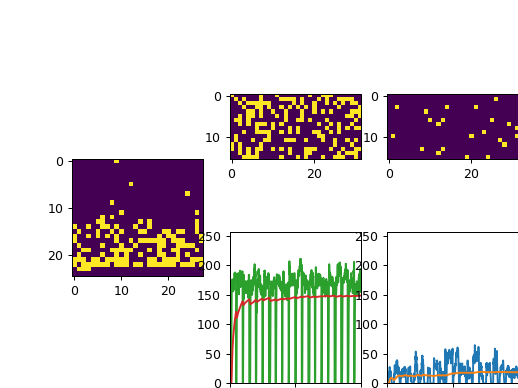

In [15]:
%matplotlib notebook
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter

xh, yh = square(snn.num_hidden)
xx, yx = square(snn.num_input)

hidden_spk = snn.all_h_spike.permute(1,0,2).flatten(0,1).view(-1, xh, yh).detach().cpu().numpy()
hidden_spk_r = snn_r.all_h_spike.permute(1,0,2).flatten(0,1).view(-1, xh, yh).detach().cpu().numpy()

x_spk = snn.all_x.permute(1,0,2).flatten(0,1).view(-1, xx, yx).detach().cpu().numpy()
#output_spk = snn.all_o_spike.view(-1,snn.num_output).detach().cpu().numpy()

print(hidden_spk.sum())
print(hidden_spk_r.sum())

fig = plt.figure()

gs = fig.add_gridspec(2,3)

ax1 = fig.add_subplot(gs[:, 0])
x_spk = snn.all_x.permute(1,0,2).flatten(0,1).view(-1, xx, yx).detach().cpu().numpy()
x_spk[0,0,0] = 1.0
im_x = ax1.imshow(x_spk[0,:,:])
    
    
ax3 = fig.add_subplot(gs[0, 1])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[0, 2])
ax6 = fig.add_subplot(gs[1, 2])

im_h = ax3.imshow(hidden_spk[0,:,:])
ax4.set_xlim(0,1000)
ax4.set_ylim(0,int(snn.num_hidden/3))
spk, = ax4.plot([])
avg_spk, = ax4.plot([])

t = np.arange(1000)
spk_data = np.zeros(1000)
avg_spk_data = np.zeros(1000)

hidden_spk[0,0,0] = 1.0
hidden_spk_r[0,0,0] = 1.0


im_x = ax1.imshow(x_spk[0,:,:])
im_h = ax3.imshow(hidden_spk[0,:,:])     # A tuple unpacking to unpack the only plot

im_h_r = ax5.imshow(hidden_spk_r[0,:,:])     # A tuple unpacking to unpack the only plot

ax4.set_xlim(0,1000)
ax4.set_ylim(0,int(snn.num_hidden/2))

ax6.set_xlim(0,1000)
ax6.set_ylim(0,int(snn.num_hidden/2))

spk, = ax4.plot([])
avg_spk, = ax4.plot([])

spk_r, = ax6.plot([])
avg_spk_r, = ax6.plot([])

t = np.arange(1000)
spk_data = np.zeros(1000)
avg_spk_data = np.zeros(1000)
spk_data_r = np.zeros(1000)
avg_spk_data_r = np.zeros(1000)

#ax.set_xlim(0, 2*np.pi)
#ax.set_ylim(-1.1, 1.1)

def animate(frame_num):
    
    spk_data[frame_num] = hidden_spk[frame_num,:,:].sum()
    avg_spk_data[frame_num] = spk_data[:frame_num].mean()

    spk_data_r[frame_num] = hidden_spk_r[frame_num,:,:].sum()
    avg_spk_data_r[frame_num] = spk_data_r[:frame_num].mean()    
    
    im_x.set_data(x_spk[frame_num,:,:])
    im_h.set_data(hidden_spk[frame_num,:,:])
    im_h_r.set_data(hidden_spk_r[frame_num,:,:])
    spk.set_data((t, spk_data))
    avg_spk.set_data((t, avg_spk_data))
    spk_r.set_data((t, spk_data_r))
    avg_spk_r.set_data((t, avg_spk_data_r))    
    
    #im_h1.set_data(hidden_spk[t,:,:])    
    return (im_x, im_h)



anim = FuncAnimation(fig, animate, frames=1000, interval=10)
#anim.save('reg_effect.gif', writer = PillowWriter(fps=15))
plt.show()

In [29]:
Dictionary1 = {'A': 'Geeks', 'B': 'For'}

In [32]:
'A' in Dictionary1.keys()

True

In [ ]:
ax[0,0]

In [ ]:
plt.imshow(hidden_spk[25,:,:])

In [ ]:
snn.all_h_spike

In [ ]:

hidden_spk[25,:]

In [ ]:
hidden_spk.

In [ ]:
snn.all_h_spike[25,0,:]

In [ ]:
snn.all_h_spike[25,0,:].shape

In [ ]:
snn.all_h_spike.shape

#### Single neuron analysis

In [ ]:
from MyDataset import *

time_window = 50
batch_size = 1
#device = 'cuda:0'
device = device

dataset_path = r'./../../datasets'
test_path = dataset_path+'/shd_digits/shd_test.h5'

#test_dataset = MyDataset(test_path, 'hd_digits', time_window, device)

test_dataset = MyDataset(path ='1_20', method= 'random', win=time_window, device=device,num_samples = None)
test_dataset.images = torch.zeros(test_dataset.images.shape)

#test_dataset.images[0, 10, 5] = 1.0
#test_dataset.images[0, 11, 5] = 1.0
test_dataset.images[0, 12, 5] = 1.0
test_dataset.images[0, 12, 6] = 1.0
test_dataset.images[0, 2, 5] = 1.0
test_dataset.images[0, 20, 5] = 1.0

In [ ]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False, drop_last=False)


In [ ]:
#tau_m = 'adp'
tau_m = 0.8305
#snn = RSNN_delay(d='shd', num_hidden=128, thresh=0.3, decay=0.3, batch_size=batch_size, win=50, device=device)
snn2 = RSNN_monitor('custom_20_10', num_hidden=10, thresh=0.3, tau_m=tau_m, batch_size=batch_size, win=time_window, device=device)
snn2.to(device)

In [ ]:
snn2.fc_ih.weight = torch.nn.Parameter(0.2*torch.ones(snn2.fc_ih.weight.shape, device=device))
snn2.fc_hh.weight = torch.nn.Parameter(0.0*torch.ones(snn2.fc_hh.weight.shape, device=device))
snn2.test(test_loader, criterion=nn.MSELoss())

In [ ]:
fig = snn2.plot_activity('x')

In [ ]:
fig = snn2.plot_activity('h')

In [ ]:
fig = snn2.plot_mem('h',[0])